# Postprocessing a Feed-Forward NN Trained based on a Sinusoidal Function

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

In [2]:
### Input Data

ROMNet_fld    = WORKSPACE_PATH + '/ROMNet/romnet/'
path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/FlameData_Noisy/FNN/MCDropOut/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/FlameData_Noisy/FNN/HamiltonianMC/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/FlameData_Noisy/FNN/BayesByBackprop/Run_1/'

NSamples      = 50

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNet_fld)

InputData.path_to_run_fld    = path_to_run_fld

InputData.PathToFigFld    = InputData.path_to_run_fld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.path_to_run_fld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventuri/WORKSPACE/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventuri/WORKSPACE/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1//Params/


In [4]:
### Loading Surrogate

surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

sys.path.insert(0, InputData.ROMNet_fld  + '/src/Model/' + surrogate_type + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.train_int_flg = 0

NN = model(InputData, InputData.path_to_run_fld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.path_to_run_fld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining ML Model from Scratch
[ROMNet]:   Compiling ML Model with Loss and Optimizer
[ROMNet]:   Saving ML Model in File: /Users/sventuri/WORKSPACE/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1//NNModel
INFO:tensorflow:Assets written to: /Users/sventuri/WORKSPACE/ROMNet/FlameData_Noisy/FNN/Deterministic/Run_1//NNModel/assets
[ROMNet]:   Summarizing ML Model Structure:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
NN_y_HL1 (Dense)             (None, 50)                100       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
______

In [5]:
### Evaluating on Training Data

#FileName  = InputData.PathToTrainDataFld + '/' + InputData.InputFile
FileName  = InputData.PathToTestDataFld + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T

#FileName  = InputData.PathToTrainDataFld + '/' + InputData.OutputFile
FileName  = InputData.PathToTestDataFld + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[InputData.OutputVars].to_numpy()

In [6]:
import tqdm

y_pred_list = []
for i in tqdm.tqdm(range(NSamples)):
    y_pred = NN.predict(InputDF[InputData.InputVars])
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

100%|██████████| 50/50 [00:02<00:00, 18.55it/s]


In [7]:
plt.figure(figsize=(12,8))
plt.scatter(Input[:,0], Output[:,0], marker='+', label='Training data')
plt.plot(Input[:,0], y_mean, 'r-',              label='Predictive mean')
plt.fill_between(Input[:,0].ravel(),  y_mean + 2 * y_sigma, y_mean - 2 * y_sigma, alpha=0.5, label='Epistemic uncertainty')
plt.legend()

In [8]:
yPredSampled = NN.predict(InputDF[InputData.InputVars].to_numpy())

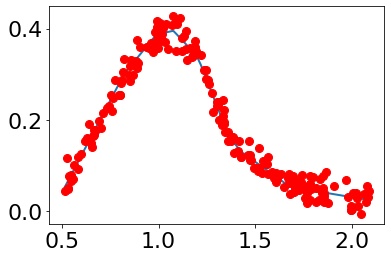

In [9]:
plt.plot(InputDF[InputData.InputVars], yPredSampled)
plt.plot(InputDF[InputData.InputVars], OutputDF[InputData.OutputVars], 'ro')